In [9]:

import pandas as pd
import pandas_datareader.data as web
from pandas import Series, DataFrame
import datetime
from datetime import date, timedelta, datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import talib as ta
import yfinance as yf
from os import walk


In [2]:
def trade(symbol,startD,endD,adxVal): 
    StartingAmount = 500_000/505
    stock = symbol
    startDate = startD
    endDate = endD
    df = pd.read_csv("C:/Users/rohan/Desktop/SchoolWork/StockMarketSimulationIQP/RohanCode/Data/clean_30y_stock_csvs/{}.csv".format(stock))
    df = df.rename(columns={"CLOSE": "Adj Close", "VOLUME": "Volume"})

    df['Datetime'] = pd.to_datetime(df['Datetime'])

    df = df[~(df['Datetime'] < startDate)]
    df = df[~(df['Datetime'] > endDate)]
    df

    df['Price_Moving_Avg'] = df['Adj Close'].rolling(window=30).mean()
    df['Vol_Moving_Avg'] = df['Volume'].rolling(window=30).mean()
    df['ADX'] = ta.ADX(df['HIGH'],df['LOW'],df['Adj Close'], timeperiod=14)
    df['RSI'] = ta.RSI(df['Adj Close'], timeperiod=14)

    daysHistory = len(df['Adj Close'])
    df = df[df['Price_Moving_Avg'].notna()]


    df['Price Lower than MAVG'] = df['Price_Moving_Avg'].gt(df['Adj Close'])
    # adj close . lt - Price moving

    df['Volume Higher than MAVG'] = df['Vol_Moving_Avg'].gt(df['Volume'])



    PL=0.00
    Total_Gain =0
    starting_price =1
    #PG -> Per_Gain

    Start_Price = (df['Adj Close'].head(1))
    Start_Price = float(Start_Price)

    End_Price = (df['Adj Close'].tail(1))
    End_Price = float(End_Price)

    Return = (PL/Start_Price)
    Return_Per = "{:.2%}".format(Return)



    benchRe = End_Price - Start_Price
    benchREP = (benchRe/Start_Price) 
    TotalPro = (benchREP) * StartingAmount

    TotalReturn = StartingAmount
    index =0
    bought = False
    
    #ADX
        #Tells how strong the trend is
            #Anything above 30 is a strong trend

    #RSI
        #Tells if there is an over buy or over sell
            #From 0-30
                #Over sell
            #From 30-70
                #Normal
            #70-100
                #Over buy

    for date_var,row in df.iterrows():
        maxValue = df.iloc[index-5:index]['Adj Close'].max()
        if math.isnan(maxValue):
            maxValue = 0

        if(df.iloc[index-1]['ADX']>adxVal):
            if not bought and df.iloc[index-1]['RSI'] > 25:
                if df.iloc[index]['Volume Higher than MAVG']==1 and df.iloc[index]['Price Lower than MAVG']==1:
                        # print(row['Datetime'],row['Adj Close'], '- Buy due to Volume + price')
                        close_adj = row['Adj Close']
                        starting_price = close_adj
                        bought = True
                elif df.iloc[index-1]['Adj Close'] > maxValue:
                    # print(row['Datetime'],row['Adj Close'], '- Buy due to going above threshhold')
                    close_adj = row['Adj Close']
                    starting_price = close_adj
                    bought = True
            else:
                if bought:
                    if (df.iloc[index]['Volume Higher than MAVG']==0 or df.iloc[index-1]['RSI'] < 75) and df.iloc[index]['Price Lower than MAVG']==0 :
                            #print(row['Datetime'],row['Adj Close'],'- Sell due to volume change')
                            close_adj = row['Adj Close']
                            single_trade_percent_gain = ((close_adj - starting_price) / starting_price) 
                            Total_Gain += single_trade_percent_gain
                            # print("This trade gain/loss results: "+str(round(single_trade_percent_gain*100,2))+"%")
                            # print()
                            bought = False

                    elif df.iloc[index-1]['Adj Close'] < maxValue: 
                            #print(row['Datetime'],row['Adj Close'],'- Sell due to going below threshhold')
                            close_adj = row['Adj Close']
                            single_trade_percent_gain = ((close_adj - starting_price) / starting_price) 
                            Total_Gain += single_trade_percent_gain
                            # print("This trade gain/loss results: "+str(round(single_trade_percent_gain*100,2))+"%")
                            # print()
                            bought = False
        index +=1
        TotalReturn = (1 + Total_Gain) * TotalReturn
        Total_Gain = 0


    if bought:
        #print(row['Datetime'],row['Adj Close'],'- SELL DUE TO LAST DAY')
        close_adj = row['Adj Close']
        single_trade_percent_gain = ((close_adj - starting_price) / starting_price) 
        Total_Gain += single_trade_percent_gain
        #print("This trade gain/loss results: {}%".format(round(single_trade_percent_gain,2)))
        TotalReturn = (1+Total_Gain)*TotalReturn
        Total_Gain = 0

    Hold_Return = (End_Price - Start_Price)
    Hold_Return_Per = "{:.2%}".format((End_Price-Start_Price)/Start_Price)
    #TotalReturn = (Total_Gain+StartingAmount)
    Total_Gain = ((TotalReturn - StartingAmount)/StartingAmount) * 100
    return round(TotalReturn-StartingAmount,2)


In [12]:
f = []
ROIall = {}
money = {}
startDate = datetime.strptime('2020-01-01',"%Y-%m-%d")
endDate = datetime.strptime('2021-01-01',"%Y-%m-%d")
sum = 0
for (dirpath, dirnames, filenames) in walk("C:/Users/rohan/Desktop/SchoolWork/StockMarketSimulationIQP/RohanCode/Data/clean_30y_stock_csvs/"):
    f.extend(filenames)
    break

for i in range (0,60):

    for stock in f:
        stock = stock[:-4]
        money[stock] = trade(stock,startDate,endDate,i)

    for s in money:
        sum+= money[s]

    print("ADX optimaztion of {} is done with profit of ${}".format(i,round(sum,2)))
    ROIall[i] = sum
    sum = 0
    money = {}


max = ROIall[0]
adxVal =0
yValue = []
for i in ROIall:
    yValue.append(ROIall[i])
    if(ROIall[i] > max):
            max = ROIall[i]
            adxVal = i

print(adxVal)
print(max)

A is done with profit of: 96.17 with ADX val of 0
AAL is done with profit of: 647.22 with ADX val of 0
AAP is done with profit of: 275.69 with ADX val of 0
AAPL is done with profit of: 3.3 with ADX val of 0
ABBV is done with profit of: -49.79 with ADX val of 0
ABC is done with profit of: 392.56 with ADX val of 0
ABMD is done with profit of: 78.98 with ADX val of 0
ABT is done with profit of: 324.84 with ADX val of 0
ACN is done with profit of: -16.48 with ADX val of 0
ADBE is done with profit of: 456.57 with ADX val of 0
ADI is done with profit of: 123.35 with ADX val of 0
ADM is done with profit of: 7.71 with ADX val of 0
ADP is done with profit of: 116.78 with ADX val of 0
ADSK is done with profit of: 201.2 with ADX val of 0
AEE is done with profit of: -19.54 with ADX val of 0
AEP is done with profit of: -67.33 with ADX val of 0
AES is done with profit of: -71.6 with ADX val of 0
AFL is done with profit of: 23.0 with ADX val of 0
AIG is done with profit of: 69.42 with ADX val of 0
AI

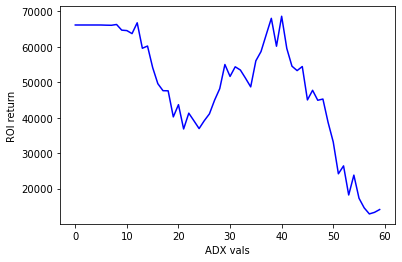

In [13]:
xValue = [x for x in range(0,60)]
plt.xlabel("ADX vals")
plt.ylabel("ROI return")
plt.plot(xValue,yValue,color='blue',label='ADX optimizaion')
plt.show()